In [1]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20.0.0 (64-bit)
Running under: macOS Sonoma 14.3.1

Matrix products: default
BLAS/LAPACK: /Users/hs0424/miniforge3/envs/r43/lib/libopenblas.0.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] digest_0.6.34   IRdisplay_1.1   utf8_1.2.4      base64enc_0.1-3
 [5] fastmap_1.1.1   glue_1.7.0      htmltools_0.5.7 repr_1.1.6     
 [9] lifecycle_1.0.4 cli_3.6.2       fansi_1.0.6     vctrs_0.6.5    
[13] pbdZMQ_0.3-11   compiler_4.3.2  tools_4.3.2     evaluate_0.23  
[17] pillar_1.9.0    crayon_1.5.2    rlang_1.1.3     jsonlite_1.8.8 
[21] IRkernel_1.3.2  uuid_1.2-0     

In [273]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(ggrepel)
    library(ggpp)
    library(dplyr)
    library(tidyr)
    library(RColorBrewer)
    library(readr) # for parse_number()
    library(clusterProfiler)
    library(patchwork)
    library(jsonlite)
})

In [274]:
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}   

In [275]:
merged_res_df = read.csv('copulacci_with_other_results.csv')

In [276]:
brca_df = merged_res_df %>%
    mutate(celltype_direction = interaction) %>%
    separate(interaction, into=c("source", "target"), sep = "=") 

In [277]:
lr_info_df = read.csv('BRCA_disease_visium_sdm_geneInter.csv')

In [310]:
brca_df = merge(
    brca_df,
    lr_info_df %>% select(c(X, interaction_name_2)) ,
    by.x = "LR_index",
    by.y = "X"
)

In [447]:
lr_info_df %>% filter(X == 'LTA_TNFRSF14')

X,interaction_name,pathway_name,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
LTA_TNFRSF14,LTA_TNFRSF14,LT,,,,,KEGG: hsa04060,Secreted Signaling,LTA - TNFRSF14


In [448]:
brca_df %>% filter(LR_index == 'LTA_TNFRSF14')

LR_index,copula_coeff,mu_x,mu_y,copula_method,copula_pval,copula_pval_fdr,scc,scc_pval,global_I,global_pval,source,target,celltype_direction,interaction_name_2
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
LTA_TNFRSF14,-0.03072072,-13.18179,-9.482116,copula,0.652694611,1.0000000,0.01988680,0.491017964,0.014788737,1.091411e-114,Surrounding tumor,Invasive,Surrounding tumor=Invasive,LTA - TNFRSF14
LTA_TNFRSF14,0.29234234,-11.70316,-9.323012,copula,0.529411765,1.0000000,-0.09827023,0.514970060,-0.257569040,1.000000e+00,Tumor,Invasive,Tumor=Invasive,LTA - TNFRSF14
LTA_TNFRSF14,0.38945946,-12.97006,-9.163143,copula,0.177835052,1.0000000,-0.09039044,0.407185629,-0.047128755,1.000000e+00,Healthy,Invasive,Healthy=Invasive,LTA - TNFRSF14
LTA_TNFRSF14,0.38747748,-13.33496,-9.609165,copula,0.000000000,0.0000000,0.11504356,0.009980040,0.032634606,2.876230e-56,Tumor,Surrounding tumor,Tumor=Surrounding tumor,LTA - TNFRSF14
LTA_TNFRSF14,0.10405405,-12.41918,-9.160802,copula,0.049900200,0.4665226,0.02887459,0.253493014,0.026764047,4.902580e-01,Surrounding tumor,Surrounding tumor,Surrounding tumor=Surrounding tumor,LTA - TNFRSF14
LTA_TNFRSF14,0.11594595,-13.07861,-9.636168,copula,0.000000000,0.0000000,0.06205619,0.001996008,0.037131378,2.424656e-03,Invasive,Invasive,Invasive=Invasive,LTA - TNFRSF14
LTA_TNFRSF14,0.13378378,-12.92001,-9.395207,copula,0.019960080,0.2587418,0.01988680,0.538922156,-0.013504281,1.000000e+00,Invasive,Surrounding tumor,Invasive=Surrounding tumor,LTA - TNFRSF14
LTA_TNFRSF14,0.19522523,-13.22482,-9.914863,copula,0.225548902,0.9993675,0.01240423,0.664670659,0.011784188,7.377321e-01,Tumor,Tumor,Tumor=Tumor,LTA - TNFRSF14
LTA_TNFRSF14,-0.51036036,-11.13258,-8.999768,copula,0.009950249,1.0000000,-0.09039045,0.381237525,0.007022494,4.970935e-01,Invasive,Healthy,Invasive=Healthy,LTA - TNFRSF14


In [174]:
brca_df %>% 
    mutate(Correlation = copula_coeff) %>%
    group_by(celltype_direction) %>%
    mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
    ungroup() %>%
    mutate(log10_p.adjust = -log10(qval)) %>%
    mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
    mutate(Cluster = celltype_direction) %>%
    #mutate(Cluster = enc2utf8(gsub("="," → ", celltype_direction))) %>%
    mutate(Correlation = copula_coeff) %>% 
    filter(LR_index == 'PGF_VEGFR1')

LR_index,copula_coeff,mu_x,mu_y,copula_method,copula_pval,copula_pval_fdr,scc,scc_pval,global_I,global_pval,source,target,celltype_direction,interaction_name_2,Correlation,qval,log10_p.adjust,log10_p.adjust_cap,Cluster
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
PGF_VEGFR1,0.1555856,-11.03202,-11.12228,copula,0.33534137,1.0000000,0.037010085,0.17964072,0.03232340,9.321288e-232,Invasive,Surrounding tumor,Invasive=Surrounding tumor,PGF - VEGFR1,0.1555856,0.64705768,0.18905701,0.18905701,Invasive=Surrounding tumor
PGF_VEGFR1,0.1793694,-11.21357,-11.20158,copula,0.29116466,1.0000000,0.037010089,0.18163673,0.01775900,1.411533e-164,Surrounding tumor,Invasive,Surrounding tumor=Invasive,PGF - VEGFR1,0.1793694,0.80243305,0.09559119,0.09559119,Surrounding tumor=Invasive
PGF_VEGFR1,0.3934234,-11.70899,-10.85088,copula,0.02522936,0.3584935,-0.002369331,0.97005988,-0.03110898,1.000000e+00,Tumor,Surrounding tumor,Tumor=Surrounding tumor,PGF - VEGFR1,0.3934234,0.21031621,0.67712725,0.67712725,Tumor=Surrounding tumor
PGF_VEGFR1,0.2170270,-11.78214,-11.15732,copula,0.02994012,0.1235128,0.022476383,0.06387226,0.01951973,1.457365e-01,Invasive,Invasive,Invasive=Invasive,PGF - VEGFR1,0.2170270,0.07785995,1.10868590,1.10868590,Invasive=Invasive
PGF_VEGFR1,-0.1139640,-11.12763,-11.81253,copula,0.75000000,1.0000000,-0.002369330,0.98003992,0.04258543,1.131704e-94,Surrounding tumor,Tumor,Surrounding tumor=Tumor,PGF - VEGFR1,-0.1139640,0.91646062,0.03788619,0.03788619,Surrounding tumor=Tumor


In [459]:
dotplot = function(
    brca_df, 
    celltype_name, 
    filter_pos=FALSE, 
    FDR_cutoff = 0.1,
    n_term = 5,
    put_arrow = FALSE
){
    brca_df = brca_df %>% filter((source == celltype_name) | 
                    (target == celltype_name))

    dacr_tbl = brca_df %>% 
            mutate(Correlation = copula_coeff) %>%
            group_by(celltype_direction) %>%
            mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
            ungroup() %>%
            mutate(log10_p.adjust = -log10(qval)) %>%
            mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
            mutate(Cluster = celltype_direction) 
    
    if (put_arrow){
        dacr_tbl = dacr_tbl %>%
            mutate(Cluster = gsub("="," → ", celltype_direction)) 
    }

    dacr_tbl = dacr_tbl %>% mutate(Correlation = copula_coeff) %>% filter(qval < FDR_cutoff) %>%
            group_by(Cluster) %>% arrange(abs(Correlation)) %>% slice_tail(n=n_term) %>% ungroup

    if (filter_pos){
        dacr_tbl = dacr_tbl %>% filter(copula_coeff > 0)
    }
        
    # dacr_tbl = brca_df %>%
    #     mutate(Correlation = copula_coeff) %>%
    #     mutate(qval = p.adjust(pval, method = "BH")) %>%
    #     mutate(log10_p.adjust = -log10(qval)) %>%
    #     mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
    #     mutate(Cluster = celltype_direction) %>%
    #     #mutate(Cluster = enc2utf8(gsub("="," → ", celltype_direction))) %>%
    #     mutate(Correlation = copula_coeff) %>% 
    #     group_by(Cluster) %>% arrange(Correlation) %>% slice_tail(n=n_term) %>% ungroup
    mat <- dacr_tbl %>% 
      # select(Correlation, celltype_direction, LR_index) %>%  
      select(Correlation, celltype_direction, interaction_name_2) %>%  
      tidyr::pivot_wider(names_from = celltype_direction, values_from = Correlation) %>% 
      data.frame() # make df as tibbles -> matrix annoying
    
    df_toplot = dacr_tbl 
    # df_toplot$lig_rec = factor(df_toplot$LR_index, levels=mat$LR_index)
    df_toplot$lig_rec = factor(df_toplot$interaction_name_2, levels=mat$interaction_name_2)
    theme_cancer = theme_bw() + theme(
        legend.position = "bottom", 
        axis.text = element_text(color="black"), 
        axis.text.x = element_text(size=14, angle = 90, vjust = 0.5, hjust=1),
        plot.margin = margin(0,0,0,0,'pt')
    )

    p_dot = ggplot(df_toplot, 
                   aes_string(
                       x="Cluster", y="lig_rec", 
                       fill="log10_p.adjust_cap", size="Correlation")) +
      geom_point(shape=21, color="black") +
      paletteer::scale_fill_paletteer_c("grDevices::Heat", direction = -1, 
                                        limits = c(-log10(FDR_cutoff), 3.1), 
                                        breaks = -log10(c(FDR_cutoff, 0.1, 0.05, 0.01, 0.001)), 
                                        labels = c(FDR_cutoff, "0.1", "0.05", "0.01", "0.001")) +
      scale_size(range=c(1,7)) +
      theme_cancer +
      theme(
          axis.text = element_text(color="black"),
          axis.text.x = element_text(size=17, angle = 90, vjust = 0.5, hjust=1)
      ) + 
      labs(y="", x="",title="", size="Correlation", fill="FDR") +
      theme(axis.text.y = element_text(size=15)) +
      theme(legend.position="right", legend.box="vertical",legend.text = element_text(size=15),
           legend.title = element_text(size=15)) +
      ggtitle(celltype_name) +
      theme(plot.title = element_text(hjust = 0.5))

    return(p_dot)
}

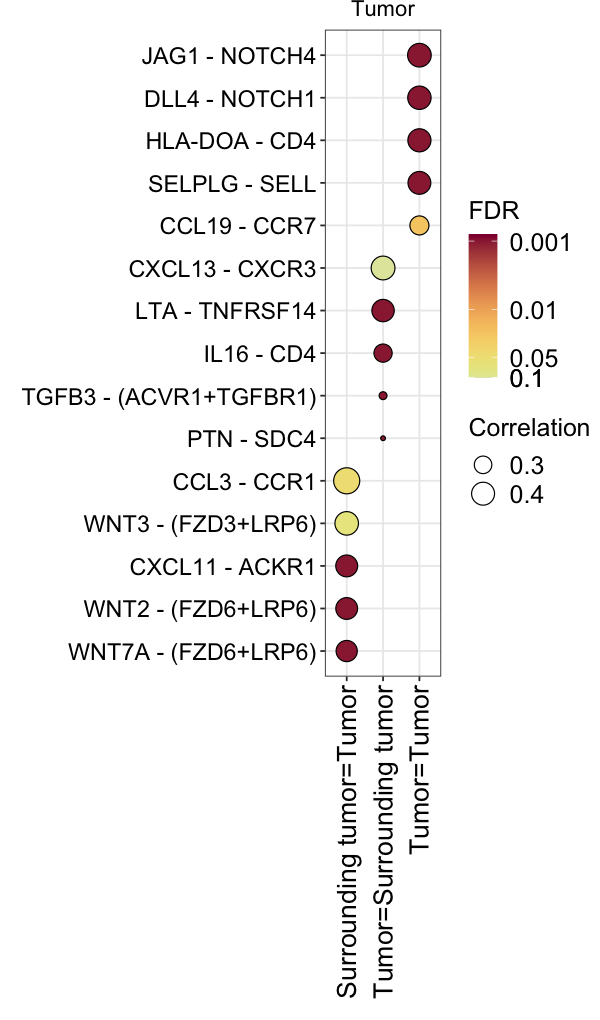

In [176]:
fig.size(8.5,5)
dotplot(brca_df, "Tumor",filter_pos=TRUE,FDR_cutoff=0.1,n_term=5)

In [177]:
fig.size(8.5,5)
parent.dir = '/Users/hs0424/Library/CloudStorage/GoogleDrive-hiraksarkar.cs@gmail.com/My Drive/Manuscripts/2023/Orator_copulacci/ISMB_figures_version_2/'

file_name = "BRCA_tumor_dotplot_3_10.png"
file_path <- file.path(parent.dir , file_name)
p1 = dotplot(brca_df, "Tumor",filter_pos=TRUE,FDR_cutoff=0.1,n_term=5, put_arrow = TRUE)
ggsave(file_path, p1, width=5, height=8.5,dpi = 500)


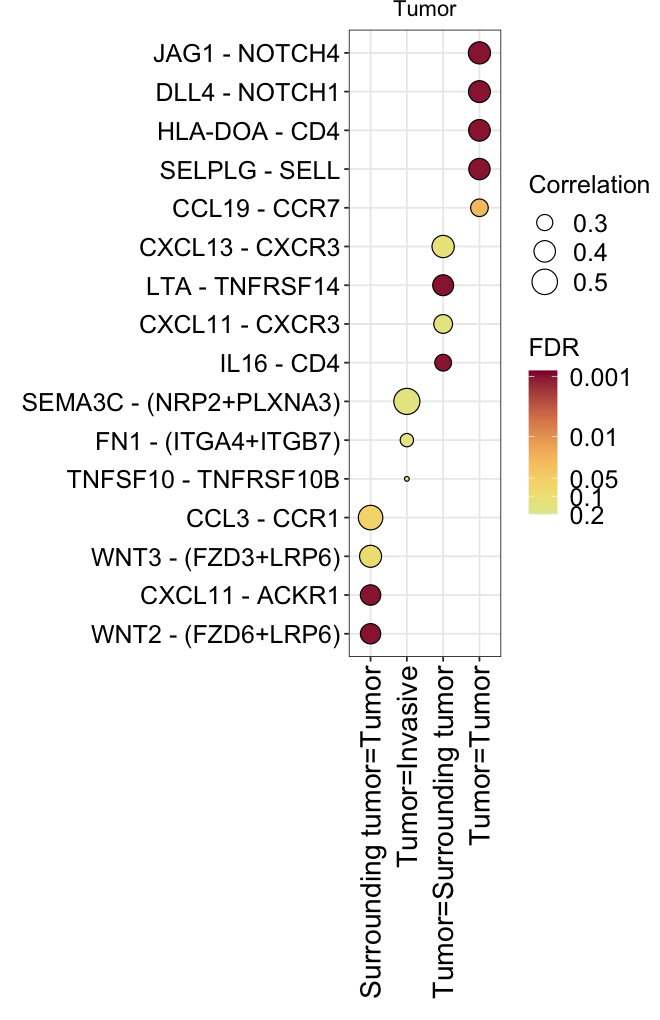

In [462]:
fig.size(8.5,5.5)
dotplot(brca_df, "Tumor",filter_pos=TRUE,FDR_cutoff=0.2,n_term=5)

In [468]:
brca_df %>% filter(LR_index == 'CXCL11_CXCR3')

LR_index,copula_coeff,mu_x,mu_y,copula_method,copula_pval,copula_pval_fdr,scc,scc_pval,global_I,global_pval,source,target,celltype_direction,interaction_name_2
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
CXCL11_CXCR3,-0.03072072,-10.75339,-10.74656,copula,0.796943231,1.00000000,0.01682363,0.560878244,0.03853056,3.180238e-01,Surrounding tumor,Surrounding tumor,Surrounding tumor=Surrounding tumor,CXCL11 - CXCR3
CXCL11_CXCR3,0.28243243,-10.96045,-12.29434,copula,0.000000000,0.00000000,0.11773979,0.001996008,0.10905629,2.124255e-04,Tumor,Tumor,Tumor=Tumor,CXCL11 - CXCR3
CXCL11_CXCR3,0.34585586,-11.14704,-11.44971,copula,0.008146640,0.24439919,0.22126310,0.001996008,0.04177869,3.797488e-91,Tumor,Surrounding tumor,Tumor=Surrounding tumor,CXCL11 - CXCR3
CXCL11_CXCR3,-0.12387387,-10.91674,-11.41257,copula,0.539419087,1.00000000,-0.04645710,0.117764471,-0.02016420,1.000000e+00,Surrounding tumor,Invasive,Surrounding tumor=Invasive,CXCL11 - CXCR3
CXCL11_CXCR3,-0.11396396,-10.62176,-11.02415,copula,0.738636364,1.00000000,0.01776838,0.864271457,0.01103916,2.598468e-01,Invasive,Healthy,Invasive=Healthy,CXCL11 - CXCR3
CXCL11_CXCR3,0.48063063,-10.53345,-10.05050,copula,0.180790960,1.00000000,0.32279289,0.023952096,0.02242301,2.980710e-01,Tumor,Healthy,Tumor=Healthy,CXCL11 - CXCR3
CXCL11_CXCR3,0.14963964,-11.01595,-11.81048,copula,0.001996008,0.01146797,0.03823336,0.007984032,0.03368100,6.506398e-03,Invasive,Invasive,Invasive=Invasive,CXCL11 - CXCR3
CXCL11_CXCR3,0.31018018,-10.43815,-11.52084,copula,0.502074689,1.00000000,0.26369292,0.071856287,0.15966324,4.043632e-25,Invasive,Tumor,Invasive=Tumor,CXCL11 - CXCR3
CXCL11_CXCR3,-0.04261261,-11.06941,-11.22839,copula,0.834355828,1.00000000,-0.04645710,0.117764471,-0.01783664,1.000000e+00,Invasive,Surrounding tumor,Invasive=Surrounding tumor,CXCL11 - CXCR3


In [467]:
lr_info_df %>% filter(X == 'CXCL13_CXCR3')

X,interaction_name,pathway_name,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CXCL13_CXCR3,CXCL13_CXCR3,CXCL,,,,,KEGG: hsa04060,Secreted Signaling,CXCL13 - CXCR3


In [464]:
fig.size(8.5,5)
parent.dir = '/Users/hs0424/Library/CloudStorage/GoogleDrive-hiraksarkar.cs@gmail.com/My Drive/Manuscripts/2023/Orator_copulacci/ISMB_figures_version_2/'

file_name = "BRCA_tumor_dotplot_4_tumors_3_11.png"
file_path <- file.path(parent.dir , file_name)
p1 = dotplot(brca_df, "Tumor",filter_pos=TRUE,FDR_cutoff=0.2,n_term=5, put_arrow = TRUE)
ggsave(file_path, p1, width=5.3, height=8.5,dpi = 500)


In [165]:
df =  brca_df %>% 
        mutate(Correlation = copula_coeff) %>%
        group_by(celltype_direction) %>%
        filter(Correlation > 0) %>%
        mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
    filter(celltype_direction == 'Tumor=Surrounding tumor')

In [166]:
df %>% filter(qval < 0.1) %>%
    group_by(celltype_direction) %>% arrange(Correlation) %>% 
    slice_tail(n=5) %>% ungroup

LR_index,copula_coeff,mu_x,mu_y,copula_method,copula_pval,copula_pval_fdr,scc,scc_pval,global_I,global_pval,source,target,celltype_direction,interaction_name_2,Correlation,qval
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
SEMA3C_NRP1_NRP2,0.1912613,-9.408046,-8.627146,copula,0.001996008,0.14,0.11318664,0.027944112,-0.04478473,1.000000e+00,Tumor,Surrounding tumor,Tumor=Surrounding tumor,SEMA3C - (NRP1+NRP2),0.1912613,0.06033333
PTN_SDC4,0.2011712,-11.645477,-8.051856,copula,0.001996008,0.14,0.06975543,0.195608782,-0.03487421,1.000000e+00,Tumor,Surrounding tumor,Tumor=Surrounding tumor,PTN - SDC4,0.2011712,0.06033333
TGFB3_ACVR1_TGFBR1,0.2071171,-10.615858,-8.940115,copula,0.001996008,0.14,0.08298050,0.087824351,0.01260277,1.220831e-09,Tumor,Surrounding tumor,Tumor=Surrounding tumor,TGFB3 - (ACVR1+TGFBR1),0.2071171,0.06033333
IL16_CD4,0.3101802,-11.742327,-10.331299,copula,0.001996008,0.14,0.16041399,0.001996008,0.08691256,0.000000e+00,Tumor,Surrounding tumor,Tumor=Surrounding tumor,IL16 - CD4,0.3101802,0.06033333
LTA_TNFRSF14,0.3874775,-13.334958,-9.609165,copula,0.002000000,0.14,0.11504356,0.009980040,0.03263461,2.876230e-56,Tumor,Surrounding tumor,Tumor=Surrounding tumor,LTA - TNFRSF14,0.3874775,0.06033333


In [59]:
df %>% filter(qval < 0.2) %>%
    group_by(celltype_direction) %>% arrange(Correlation) %>% 
    slice_tail(n=5) %>% ungroup

copula_coeff,mu_x,mu_y,copula_method,copula_pval,copula_pval_fdr,scc,scc_pval,global_I,global_pval,source,target,LR_index,celltype_direction,Correlation,qval
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
0.3617117,-12.18228,-10.385004,copula,0.030612245,0.4017857,0.030101349,0.50698603,-0.04238064,1.000000e+00,Tumor,Surrounding tumor,WNT7B_FZD7_LRP5,Tumor=Surrounding tumor,0.3617117,0.19441461
0.3795495,-11.48913,-10.873101,copula,0.021052632,0.3577919,-0.012703274,0.79840319,-0.02205551,1.000000e+00,Tumor,Surrounding tumor,ANGPTL2_TLR4,Tumor=Surrounding tumor,0.3795495,0.17001292
0.3874775,-13.33496,-9.609165,copula,0.000000000,0.0000000,0.115043562,0.00998004,0.03263461,2.876230e-56,Tumor,Surrounding tumor,LTA_TNFRSF14,Tumor=Surrounding tumor,0.3874775,0.00000000
0.3934234,-11.70899,-10.850878,copula,0.025229358,0.3584935,-0.002369331,0.97005988,-0.03110898,1.000000e+00,Tumor,Surrounding tumor,PGF_VEGFR1,Tumor=Surrounding tumor,0.3934234,0.17078570
0.4191892,-11.90784,-11.449714,copula,0.005747126,0.2028202,0.045366323,0.42714571,0.03628294,3.766664e-69,Tumor,Surrounding tumor,CXCL13_CXCR3,Tumor=Surrounding tumor,0.4191892,0.09853021


In [40]:
fdr_cutoffs <- seq(0, 0.5, by = 0.01)
lr_counts <- sapply(fdr_cutoffs, function(cutoff) sum(df$qval <= cutoff))
fdr_df <- data.frame(fdr_cutoff = fdr_cutoffs, lr_counts = lr_counts)

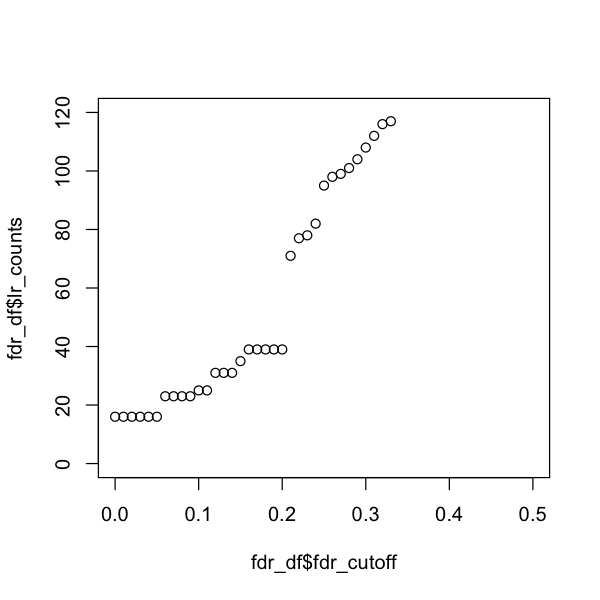

In [49]:
fig.size(5,5)
plot(fdr_df$fdr_cutoff, fdr_df$lr_counts,ylim=c(0,120))

In [185]:
library(extrafont) 
font_import()

Registering fonts with R



Importing fonts may take a few minutes, depending on the number of fonts and the speed of the system.
Continue? [y/n]  y


Scanning ttf files in /Library/Fonts/, /System/Library/Fonts, /System/Library/Fonts/Supplemental, ~/Library/Fonts/ ...

Extracting .afm files from .ttf files...

/System/Library/Fonts/Supplemental/Arial Unicode.ttf
 => /Users/hs0424/miniforge3/envs/r43/lib/R/library/extrafontdb/metrics/Arial Unicode

/Library/Fonts/kalpurush.ttf
 => /Users/hs0424/miniforge3/envs/r43/lib/R/library/extrafontdb/metrics/kalpurush

/Library/Fonts/Siyamrupali.ttf
 => /Users/hs0424/miniforge3/envs/r43/lib/R/library/extrafontdb/metrics/Siyamrupali

/System/Library/Fonts/Apple Braille Outline 6 Dot.ttf
 => /Users/hs0424/miniforge3/envs/r43/lib/R/library/extrafontdb/metrics/Apple Braille Outline 6 Dot

/System/Library/Fonts/Apple Braille Outline 8 Dot.ttf
 => /Users/hs0424/miniforge3/envs/r43/lib/R/library/extrafontdb/metrics/Apple Braille Outline 8 Dot

/System/Library/Fonts/Apple Braille Pinpoint 6 Dot.ttf
 => /Users/hs0424/miniforge3/envs/r43/lib/R/library/extrafontdb/metrics/Apple Braille Pinpoint 6 Dot

/Sy

In [243]:
loadfonts(device='all')

.Keyboard already registered with pdfFont().

.New York already registered with pdfFont().

.SF Arabic already registered with pdfFont().

.SF Arabic Rounded already registered with pdfFont().

.SF Armenian already registered with pdfFont().

.SF Armenian Rounded already registered with pdfFont().

.SF Camera already registered with pdfFont().

.SF Compact already registered with pdfFont().

.SF Compact Rounded already registered with pdfFont().

.SF Georgian already registered with pdfFont().

.SF Georgian Rounded already registered with pdfFont().

.SF Hebrew already registered with pdfFont().

.SF Hebrew Rounded already registered with pdfFont().

.SF NS Mono already registered with pdfFont().

.SF NS Rounded already registered with pdfFont().

Academy Engraved LET already registered with pdfFont().

Andale Mono already registered with pdfFont().

More than one version of regular/bold/italic found for Apple Braille. Skipping setup for this font.

AppleMyungjo already registered with

In [245]:
#fonts()

In [315]:
xcol = "copula_coeff"
ycol = "scc"
gpair = 'Tumor=Surrounding tumor'
use_cutoff=TRUE
use_diff=TRUE
FDR_cutoff=0.1
ntop=5



In [433]:
plot_scatter = function(
    brca_df,
    xcol = "copula_coeff",
    ycol = "scc",
    gpair = 'Tumor=Surrounding tumor',
    use_cutoff=TRUE,
    use_diff=TRUE,
    FDR_cutoff=0.1,
    ntop=5,
    p_value="qval",
    x_shift=0.2,
    y_shift=0.2,
    pad = 0.1
){

    df_ct = brca_df %>% 
        mutate(Correlation = copula_coeff) %>%
        group_by(celltype_direction) %>%
        mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
        ungroup() %>%
        mutate(log10_p.adjust = -log10(qval)) %>%
        mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
        mutate(Cluster = celltype_direction) %>%
        filter(celltype_direction == gpair)
    
    df_ct = df_ct %>% 
        select(c(LR_index, copula_coeff, log10_p.adjust_cap, scc, 
                 global_I, qval, interaction_name_2))
    
    xmax = max(df_ct[[xcol]]) 
    xmin = min(df_ct[[xcol]])
    ymax = max(df_ct[[ycol]]) 
    ymin = min(df_ct[[ycol]])
    gmin = min(xmin, ymin)
    gmax = max(xmax, ymax)
    gmax = gmax + pad
    
    df_ct$method_diff = abs(df_ct[[xcol]] - df_ct[[ycol]])
    if(use_cutoff){
            if (use_diff){
                top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                    arrange(method_diff) %>% 
                    slice_tail(n=ntop) %>% pull(LR_index)
            }else{
                top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                    arrange(abs(copula_coeff)) %>% 
                    slice_tail(n=ntop) %>% pull(LR_index)    
            }
            
        }else{
            if (use_diff){
                top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                    arrange(method_diff) %>% 
                    slice_tail(n=ntop) %>% pull(LR_index)
            }else{
                top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                    arrange(abs(copula_coeff)) %>% 
                    slice_tail(n=ntop) %>% pull(LR_index)    
            }
        }
    
    
    
    p = ggplot(df_ct, aes_string(x = xcol, y = ycol, color = p_value)) +
          scale_color_gradient(
            # limits = c(-log10(max(df_ct$qval)), 3.1), 
            # breaks = -log10(c(0.9, 0.1, 0.05, 0.01, 0.001)), 
            # labels = c("0.9", "0.1", "0.05", "0.01", "0.001"),
            low = "blue", high = "grey") +
          geom_point(alpha = 0.6, size=3) + 
          geom_point(data = df_ct %>% filter(LR_index %in% top_candidates), 
                     color = "red", size = 3.5, stroke=1.3, shape = 1) +
        xlim(-gmax,gmax) +
        ylim(-gmax,gmax) +
        labs(color ='FDR') +
        geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal dashed line
          geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical dashed line
        geom_label_repel(
            data = df_ct %>% filter(LR_index %in% top_candidates),
            aes_string(x = xcol, y= ycol, label = "interaction_name_2"),
            position=position_nudge_center(x = x_shift,y= y_shift ,
                                           center_x = 0.0
                                           # center_y = 0.0
                                          ),
            family = "Poppins",
            size = 5,
            min.segment.length = 0, 
            seed = 42, 
            box.padding = 0.1,
            max.overlaps = Inf,
            xlim = c(NA, NA),
            ylim = c(NA, NA),
            arrow = arrow(length = unit(0.01, "npc")),
            # nudge_x = .1,
            # #nudge_y = -.1,
            #fill="white",
            color = "red"
          ) +
          theme_bw() +
          theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            axis.line = element_line(colour = "black"),
            # axis.title.x = element_blank(),
            # axis.title.y = element_blank(),
            axis.text.x = element_text(family = "Helvetica", size = 18, color = "black"),
            axis.text.y = element_text(family = "Helvetica", size = 18, color = "black"),
            legend.text = element_text(size=16),
            legend.title = element_text(size=16)
          )
    return(p)
}

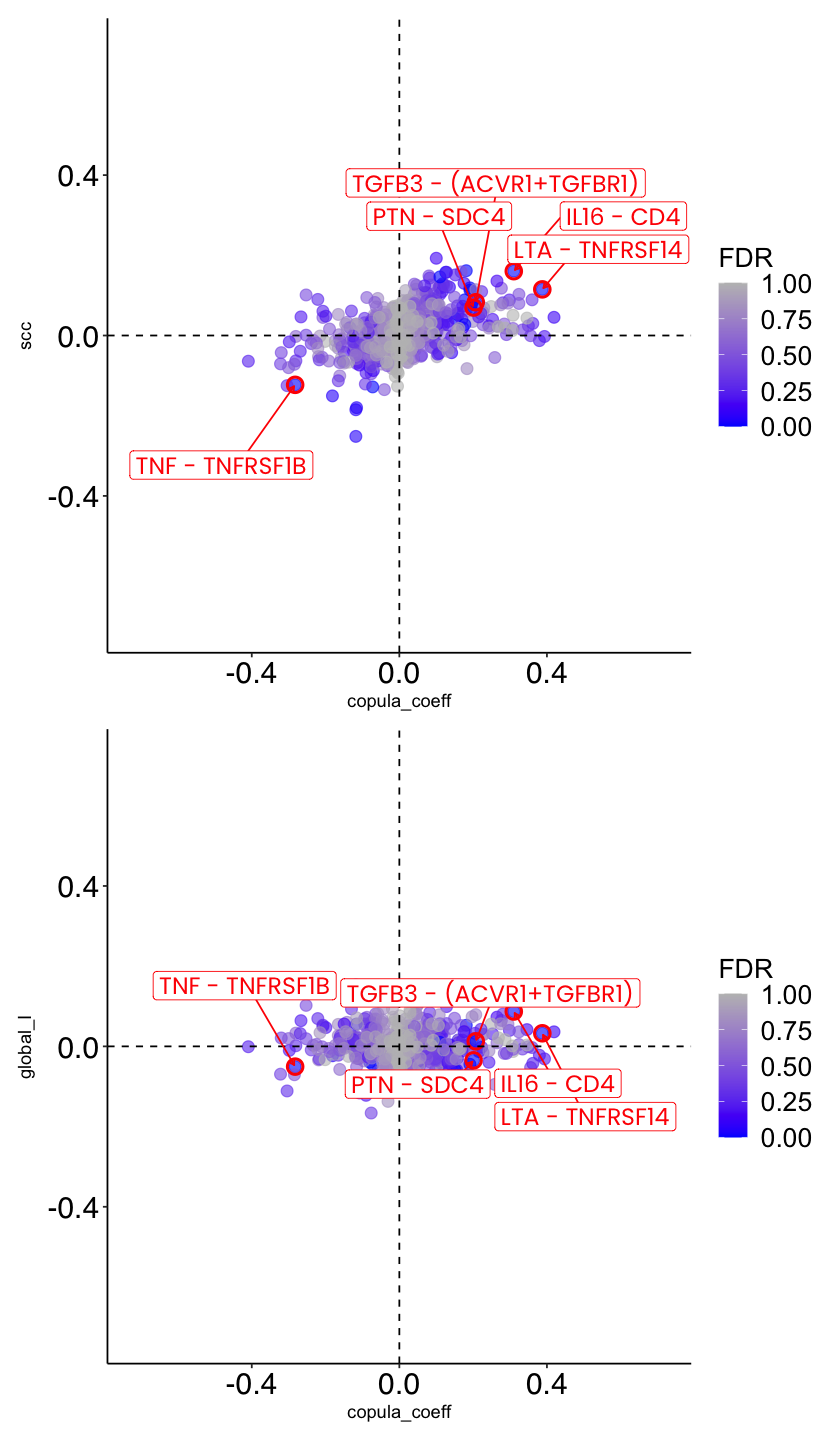

In [434]:
fig.size(12, 7)
gpair = 'Tumor=Surrounding tumor'
p1 = plot_scatter(brca_df, "copula_coeff", "scc", gpair,ntop=5,FDR_cutoff=0.1, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3)
p2 = plot_scatter(brca_df, "copula_coeff", "global_I", gpair,ntop=5,FDR_cutoff=0.1, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3,x_shift=0.1, y_shift=-0.2)
p3 = p1 / p2
p3

In [435]:
file_name = "BRCA_tumor_surrounding_tumor_label_scatter_03_10.png"
file_path <- file.path(parent.dir , file_name)
ggsave(file_path, p3, width=7, height=12,dpi = 500)

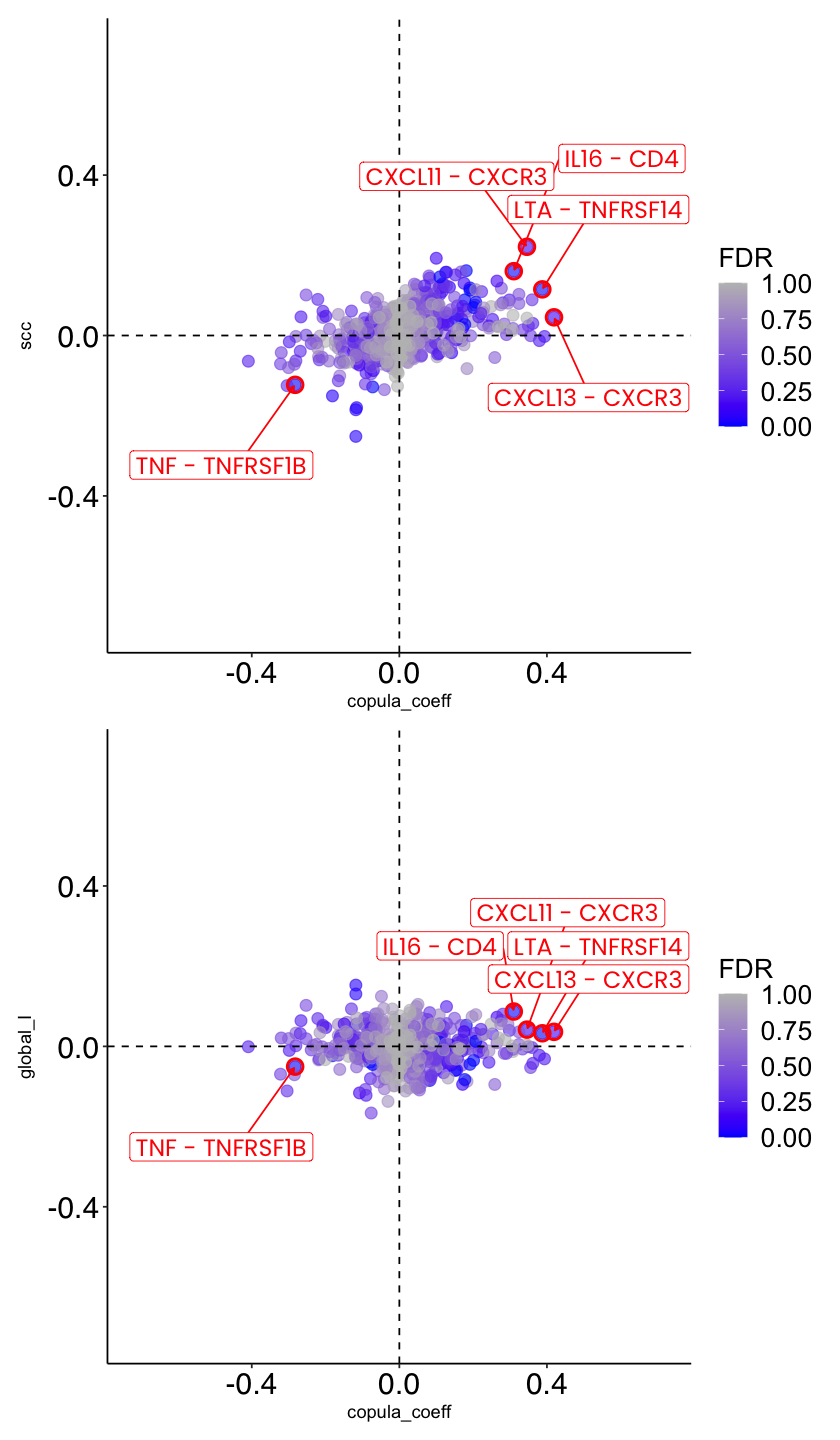

In [444]:
fig.size(12, 7)
gpair = 'Tumor=Surrounding tumor'
p1 = plot_scatter(brca_df, "copula_coeff", "scc", gpair,ntop=5,FDR_cutoff=0.2, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3)
p2 = plot_scatter(brca_df, "copula_coeff", "global_I", gpair,ntop=5,FDR_cutoff=0.2, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3,x_shift=0.2, y_shift=0.2)
p3 = p1 / p2
p3

In [445]:
file_name = "BRCA_tumor_surrounding_tumor_label_scatter_03_11.png"
file_path <- file.path(parent.dir , file_name)
ggsave(file_path, p3, width=7, height=12,dpi = 500)

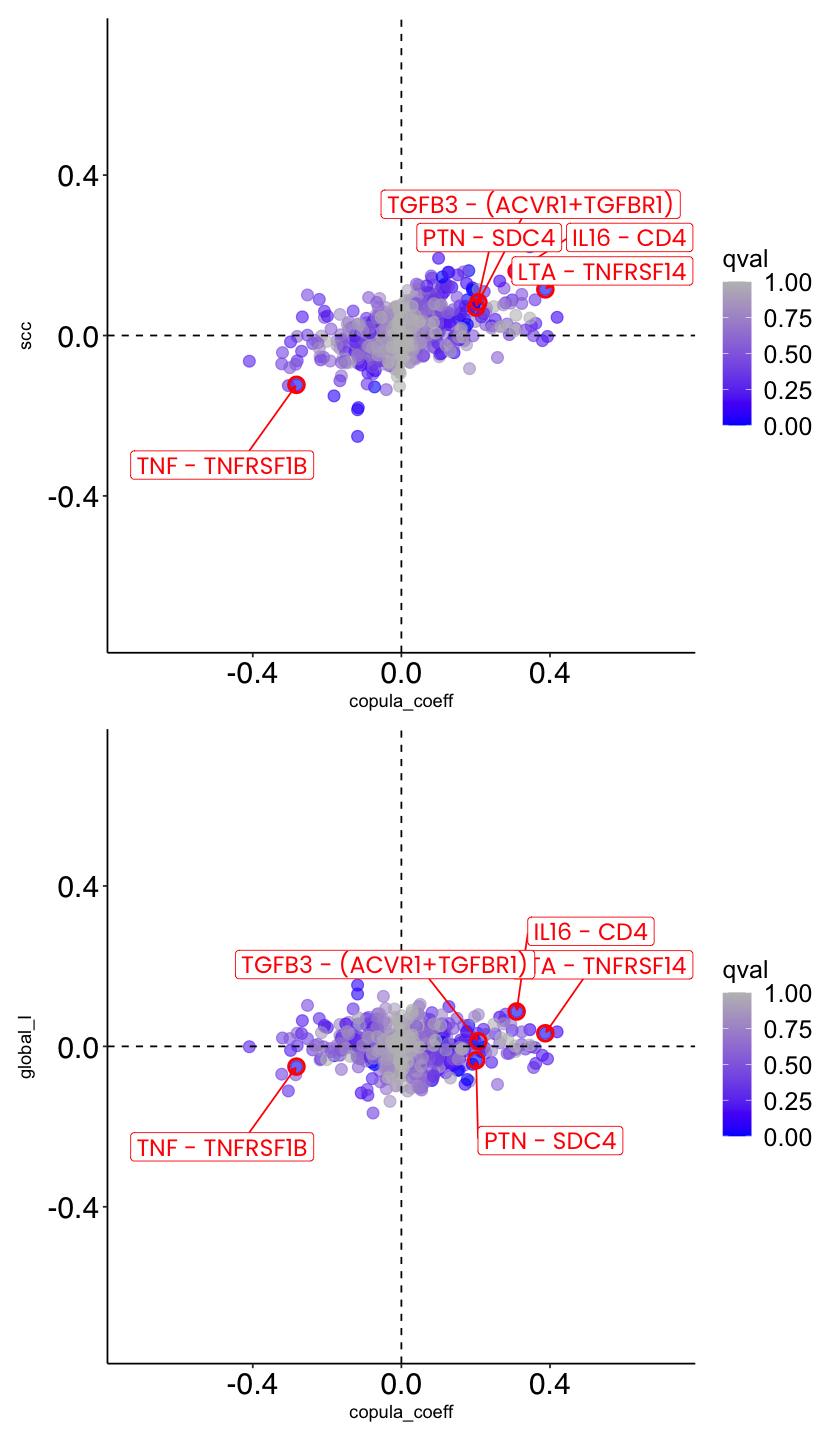

In [410]:
fig.size(12, 7)
gpair = 'Tumor=Surrounding tumor'
p1 = plot_scatter(brca_df, "copula_coeff", "scc", gpair,ntop=5,FDR_cutoff=0.1, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3)
p2 = plot_scatter(brca_df, "copula_coeff", "global_I", gpair,ntop=5,FDR_cutoff=0.1, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3)
p3 = p1 / p2
p3

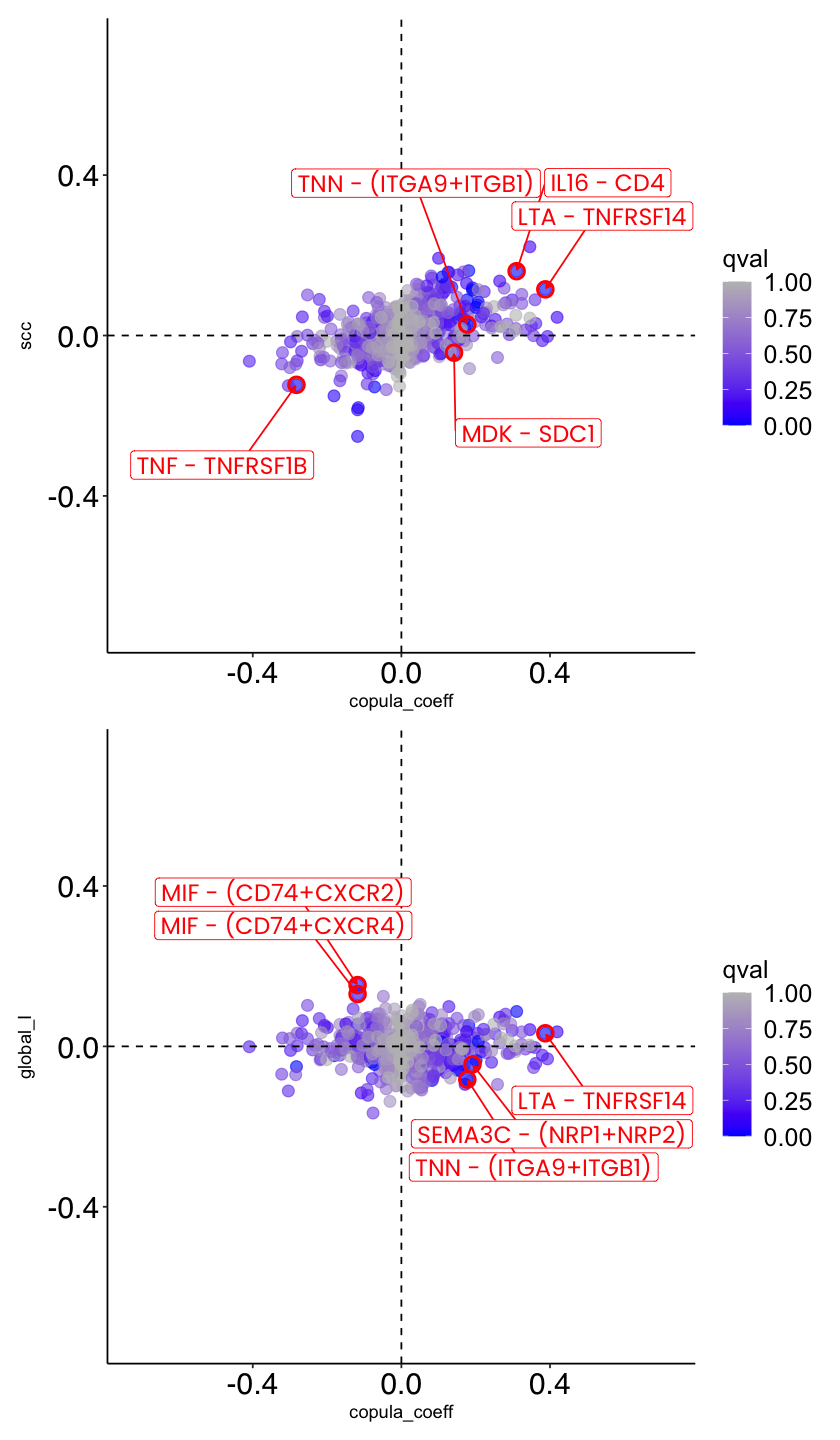

In [409]:
fig.size(12, 7)
gpair = 'Tumor=Surrounding tumor'
p1 = plot_scatter(brca_df, "copula_coeff", "scc", gpair,ntop=5,FDR_cutoff=0.1, 
                  use_cutoff=TRUE, pad=0.3)
p2 = plot_scatter(brca_df, "copula_coeff", "global_I", gpair,ntop=5,FDR_cutoff=0.1, 
                  use_cutoff=TRUE, pad=0.3)
p3 = p1 / p2
p3

In [285]:
plot_scatter = function(brca_df, xcol, ycol, gpair, FDR_cutoff=0.1, ntop=5,
                        use_diff=TRUE,
                        use_cutoff=FALSE){
    
    df_ct = brca_df %>% 
    mutate(Correlation = copula_coeff) %>%
    group_by(celltype_direction) %>%
    mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
    ungroup() %>%
    mutate(log10_p.adjust = -log10(qval)) %>%
    mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
    mutate(Cluster = celltype_direction) %>%
    filter(celltype_direction == gpair)

    
    #df_ct$LR_index = df_ct$interaction_name_2
    df_ct = df_ct %>% select(c(LR_index, copula_coeff, log10_p.adjust_cap, scc, global_I, qval)) 
    xmax = max(df_ct[[xcol]]) 
    xmin = min(df_ct[[xcol]])
    ymax = max(df_ct[[ycol]]) 
    ymin = min(df_ct[[ycol]])
    gmin = min(xmin, ymin)
    gmax = max(xmax, ymax)
    df_ct$method_diff = abs(df_ct[[xcol]] - df_ct[[ycol]])
    if(use_cutoff){
        if (use_diff){
            top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                arrange(method_diff) %>% 
                slice_tail(n=ntop) %>% pull(LR_index)
        }else{
            top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                arrange(abs(copula_coeff)) %>% 
                slice_tail(n=ntop) %>% pull(LR_index)    
        }
        
    }else{
        if (use_diff){
            top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                arrange(method_diff) %>% 
                slice_tail(n=ntop) %>% pull(LR_index)
        }else{
            top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                arrange(abs(copula_coeff)) %>% 
                slice_tail(n=ntop) %>% pull(LR_index)    
        }
    }
    print(top_candidates)
    print(df_ct %>% filter(LR_index %in% top_candidates))
    #p_value = "log10_p.adjust_cap"
    p_value = "qval"
    p_scatter = ggplot(df_ct, aes_string(x = xcol, y = ycol, color = p_value)) +
      scale_color_gradient(
        # limits = c(-log10(max(df_ct$qval)), 3.1), 
        # breaks = -log10(c(0.9, 0.1, 0.05, 0.01, 0.001)), 
        # labels = c("0.9", "0.1", "0.05", "0.01", "0.001"),
        low = "blue", high = "grey") +
      geom_point(alpha = 0.6, size=3) + 
      geom_point(data = df_ct %>% filter(LR_index %in% top_candidates), 
                 color = "red", size = 3.5, stroke=1.3, shape = 1) +  # Red border for specific points
      geom_text_repel(
        data = df_ct %>% filter(LR_index %in% top_candidates),
        aes_string(x = xcol, y= ycol, label = "LR_index"),
        position=position_nudge_center(x = 0.1, center_x = 0.0),
        family = "Poppins",
        size = 5,
        min.segment.length = 0, 
        seed = 42, 
        box.padding = 0.1,
        max.overlaps = Inf,
        arrow = arrow(length = unit(0.01, "npc")),
        # nudge_x = .1,
        # #nudge_y = -.1,
        color = "red"
      ) +
      geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal dashed line
      geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical dashed line
      theme_bw() +
      theme(
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        axis.line = element_line(colour = "black"),
        # axis.title.x = element_blank(),
        # axis.title.y = element_blank(),
        axis.text.x = element_text(family = "Helvetica", size = 18, color = "black"),
        axis.text.y = element_text(family = "Helvetica", size = 18, color = "black"),
        legend.text = element_text(size=15),
        legend.title = element_text(size=15)
      ) +
        xlim(gmin,gmax) +
        ylim(gmin,gmax) +
      labs(color = "FDR")
    
    return(p_scatter)
}

[1] "IL16_CD4"        "TNN_ITGA9_ITGB1" "TNF_TNFRSF1B"    "MDK_SDC1"       
[5] "LTA_TNFRSF14"   
# A tibble: 5 × 7
  LR_index   copula_coeff log10_p.adjust_cap     scc global_I   qval method_diff
  <chr>             <dbl>              <dbl>   <dbl>    <dbl>  <dbl>       <dbl>
1 TNN_ITGA9…        0.177               3     0.0275  -0.0826 0            0.150
2 LTA_TNFRS…        0.387               3     0.115    0.0326 0            0.272
3 TNF_TNFRS…       -0.282               3    -0.123   -0.0505 0            0.159
4 IL16_CD4          0.310               3     0.160    0.0869 0            0.150
5 MDK_SDC1          0.142               1.01 -0.0428  -0.0461 0.0984       0.185
[1] "SEMA3C_NRP1_NRP2" "MIF_CD74_CXCR4"   "TNN_ITGA9_ITGB1"  "MIF_CD74_CXCR2"  
[5] "LTA_TNFRSF14"    
# A tibble: 5 × 7
  LR_index   copula_coeff log10_p.adjust_cap     scc global_I   qval method_diff
  <chr>             <dbl>              <dbl>   <dbl>    <dbl>  <dbl>       <dbl>
1 TNN_ITGA9…        0.177         

Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”


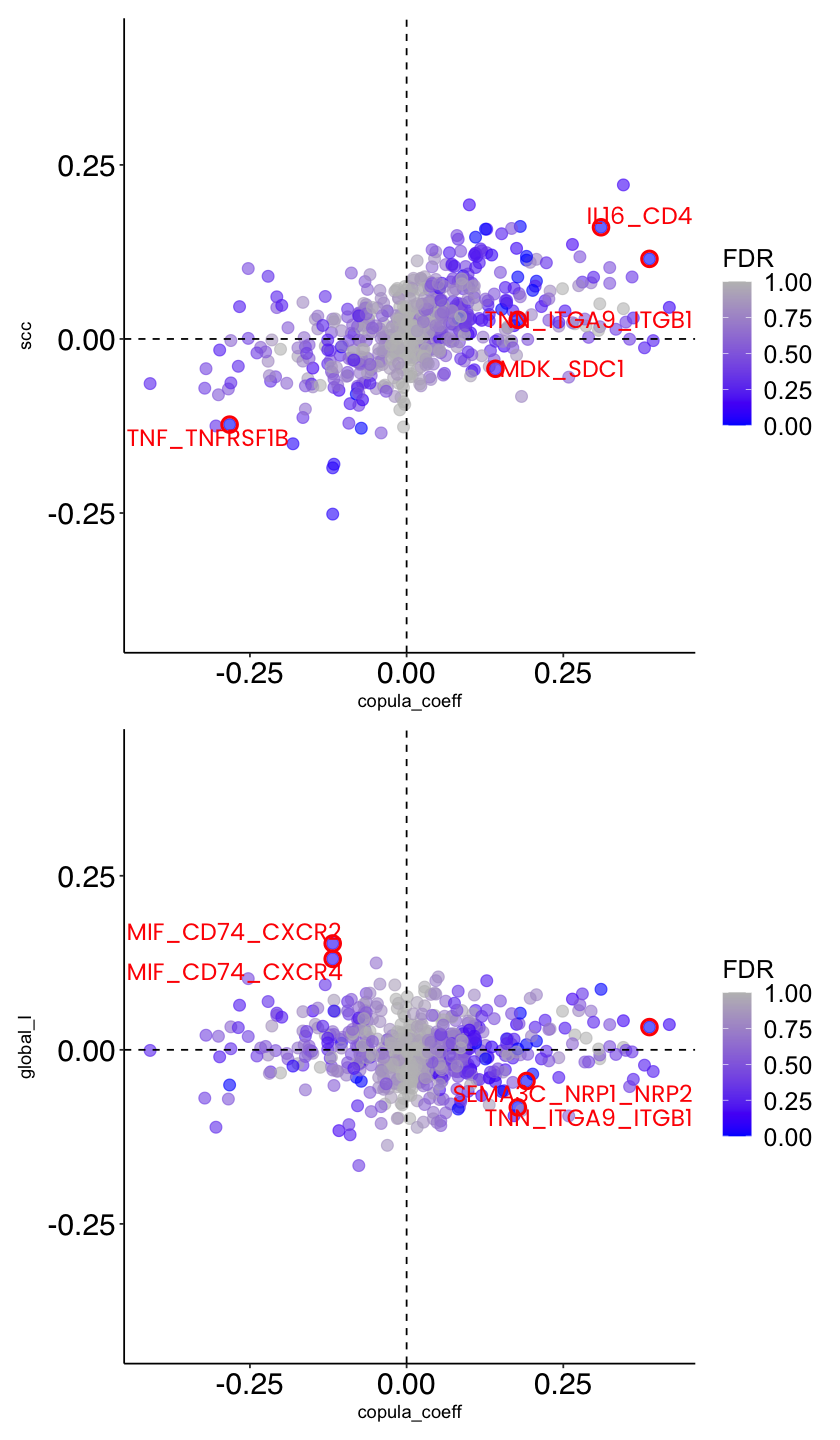

In [286]:
gpair = 'Tumor=Surrounding tumor'
p1 = plot_scatter(brca_df, "copula_coeff", "scc", gpair,ntop=5,FDR_cutoff=0.1, use_cutoff=TRUE)
p2 = plot_scatter(brca_df, "copula_coeff", "global_I", gpair,ntop=5,FDR_cutoff=0.1, use_cutoff=TRUE)
fig.size(12,7)
p3 = p1 / p2
p3

[1] "PTN_SDC4"           "TGFB3_ACVR1_TGFBR1" "TNF_TNFRSF1B"      
[4] "IL16_CD4"           "LTA_TNFRSF14"      
# A tibble: 5 × 7
  LR_index    copula_coeff log10_p.adjust_cap     scc global_I  qval method_diff
  <chr>              <dbl>              <dbl>   <dbl>    <dbl> <dbl>       <dbl>
1 TGFB3_ACVR…        0.207                  3  0.0830   0.0126     0       0.124
2 LTA_TNFRSF…        0.387                  3  0.115    0.0326     0       0.272
3 TNF_TNFRSF…       -0.282                  3 -0.123   -0.0505     0       0.159
4 IL16_CD4           0.310                  3  0.160    0.0869     0       0.150
5 PTN_SDC4           0.201                  3  0.0698  -0.0349     0       0.131
[1] "PTN_SDC4"           "TGFB3_ACVR1_TGFBR1" "TNF_TNFRSF1B"      
[4] "IL16_CD4"           "LTA_TNFRSF14"      
# A tibble: 5 × 7
  LR_index    copula_coeff log10_p.adjust_cap     scc global_I  qval method_diff
  <chr>              <dbl>              <dbl>   <dbl>    <dbl> <dbl>       <dbl>
1 TGFB3_A

Warning message:
“Removed 16 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 16 rows containing missing values (`geom_text_repel()`).”


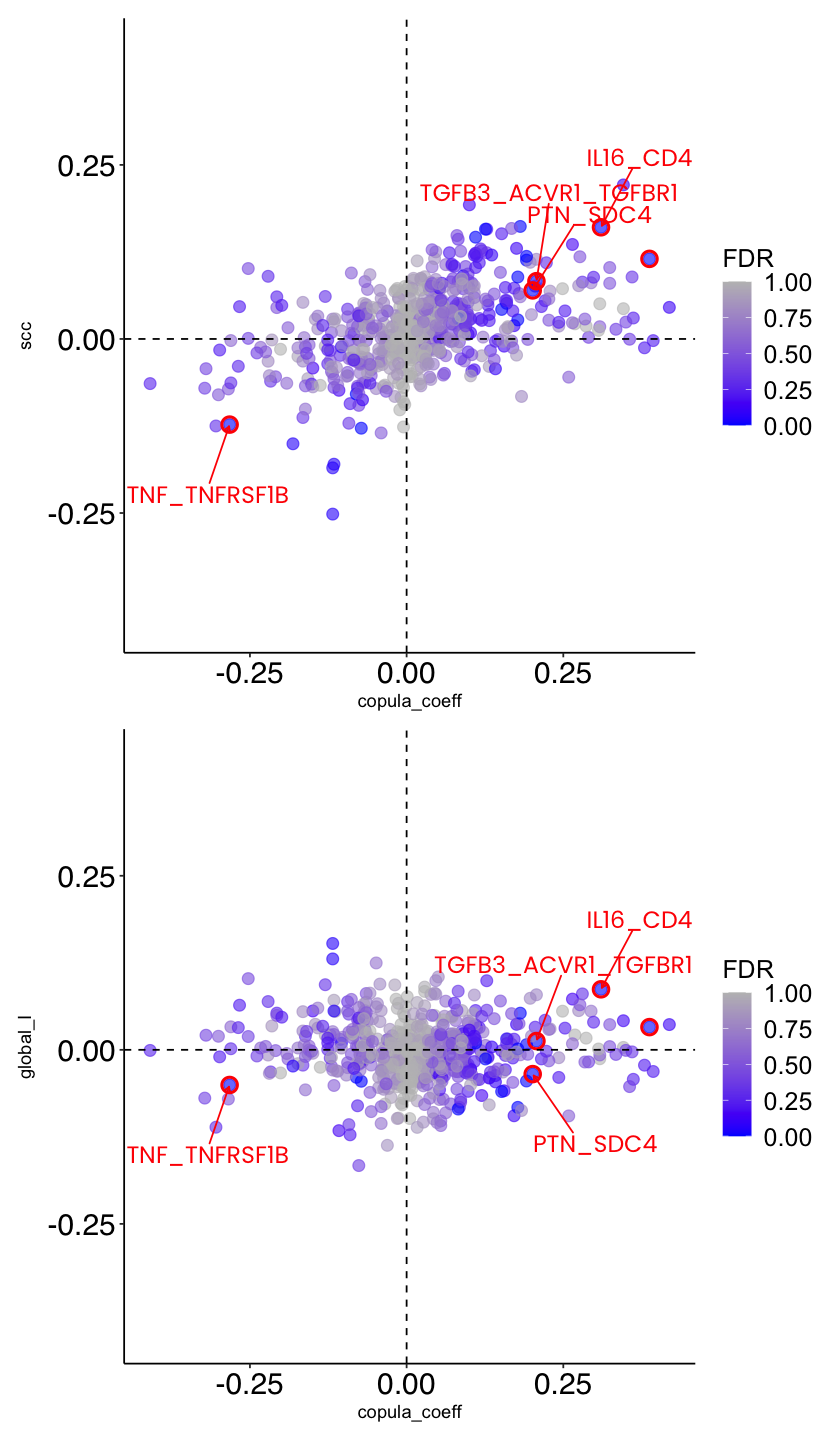

In [280]:
gpair = 'Tumor=Surrounding tumor'
p1 = plot_scatter(brca_df, "copula_coeff", "scc", gpair,ntop=5,FDR_cutoff=0.1,
                  use_diff=FALSE,
                  use_cutoff=TRUE)
p2 = plot_scatter(brca_df, "copula_coeff", "global_I", gpair,ntop=5,FDR_cutoff=0.1,
                  use_diff=FALSE,
                  use_cutoff=TRUE)
fig.size(12,7)
p3 = p1 / p2
p3

In [112]:
file_name = "BRCA_tumor_surrounding_tumor_scatter_03_10.png"
file_path <- file.path(parent.dir , file_name)
ggsave(file_path, p3, width=7, height=12,dpi = 500)

In [137]:
brca_df %>% filter(celltype_direction == 'Tumor=Surrounding tumor') %>%
    mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
    arrange(desc(copula_coeff)) %>% arrange(qval) %>% 
    select(c(copula_coeff, LR_index, copula_pval_fdr, qval,copula_pval))%>%  head(10)

,copula_coeff,LR_index,copula_pval_fdr,qval,copula_pval
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,0.3874775,LTA_TNFRSF14,0.14,0.08213333,0.002000000
2,0.3101802,IL16_CD4,0.14,0.08213333,0.001996008
3,0.2071171,TGFB3_ACVR1_TGFBR1,0.14,0.08213333,0.001996008
4,0.2011712,PTN_SDC4,0.14,0.08213333,0.001996008
5,0.1912613,SEMA3C_NRP1_NRP2,0.14,0.08213333,0.001996008
6,0.1912613,C3_ITGAM_ITGB2,0.14,0.08213333,0.001996008
7,0.1813514,AREG_EGFR_ERBB2,0.14,0.08213333,0.001996008
8,0.1773874,TNN_ITGA9_ITGB1,0.14,0.08213333,0.001996008
9,0.1773874,C3_ITGAX_ITGB2,0.14,0.08213333,0.001996008


copula_coeff,mu_x,mu_y,copula_method,copula_pval,copula_pval_fdr,scc,scc_pval,global_I,global_pval,source,target,LR_index,celltype_direction
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
-0.014864865,-12.673602,-8.328947,copula,0.61876248,1.0000000,0.015318368,0.586826347,0.028153050,0.47538625,Surrounding tumor,Surrounding tumor,COL4A4_ITGA9_ITGB1,Surrounding tumor=Surrounding tumor
0.032702703,-7.753484,-8.328947,copula,0.99600798,1.0000000,0.050607246,0.075848303,0.018097225,0.62521360,Surrounding tumor,Surrounding tumor,COL6A1_ITGA9_ITGB1,Surrounding tumor=Surrounding tumor
0.018828829,-7.199997,-8.328947,copula,0.99401198,1.0000000,0.042455317,0.125748503,-0.023482260,0.99999975,Surrounding tumor,Surrounding tumor,COL6A2_ITGA9_ITGB1,Surrounding tumor=Surrounding tumor
-0.044594595,-13.339097,-8.328947,copula,0.22355289,1.0000000,-0.020510291,0.475049900,-0.022288439,0.99999975,Surrounding tumor,Surrounding tumor,COL4A3_ITGA9_ITGB1,Surrounding tumor=Surrounding tumor
0.034684685,-8.103913,-8.328947,copula,0.97005988,1.0000000,0.086300187,0.003992016,0.079652177,0.01718517,Surrounding tumor,Surrounding tumor,COL6A3_ITGA9_ITGB1,Surrounding tumor=Surrounding tumor
-0.080270270,-12.283836,-8.328947,copula,0.03592814,0.3128842,-0.052651152,0.071856287,-0.035237552,0.99999975,Surrounding tumor,Surrounding tumor,COL4A5_ITGA9_ITGB1,Surrounding tumor=Surrounding tumor
0.030720721,-10.097215,-8.328947,copula,0.91017964,1.0000000,0.039569941,0.147704591,0.041963601,0.27684161,Surrounding tumor,Surrounding tumor,LAMA4_ITGA9_ITGB1,Surrounding tumor=Surrounding tumor
-0.064414414,-8.964141,-8.328947,copula,0.02395210,0.2202588,-0.107753714,0.001996008,-0.103098015,0.99999975,Surrounding tumor,Surrounding tumor,COL9A2_ITGA9_ITGB1,Surrounding tumor=Surrounding tumor
-0.014864865,-12.502243,-8.328947,copula,0.61477046,1.0000000,-0.017093544,0.524950100,-0.032216269,0.99999975,Surrounding tumor,Surrounding tumor,COL9A3_ITGA9_ITGB1,Surrounding tumor=Surrounding tumor
